In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy as sp
import re
import os, sys
import json
from collections import defaultdict

%matplotlib inline

In [305]:
data_directory = './dataset/deezer_clean_data/'
graph_directory = './graphs/'
country = 'HU'
csv_name = country + '_edges.csv'
genre_json = country + '_genres.json'
top_5000_subset_directory = data_directory + 'top_5000_edges_subset/'

if not os.path.exists(graph_directory):
    os.makedirs(graph_directory)
if not os.path.exists(top_5000_subset_directory):
    os.makedirs(top_5000_subset_directory)

## Read and sample friendship data

In [306]:
df = pd.read_csv(data_directory + csv_name)
df.head(10)

,node_1,node_2
0,0,24208
1,0,24445
2,0,18055
3,0,26575
4,0,12596
5,0,28092
6,0,14484
7,0,14809
8,0,47328
9,0,32542


In [307]:
# Get the nodes with top degrees
df['degree1'] = df.groupby('node_1')['node_1'].transform('count')
df['degree2'] = df.groupby('node_2')['node_2'].transform('count')
degree_sorted_df = df.sort_values('degree1', ascending=False)
degree_sorted_df.head(10)

,node_1,node_2,degree1,degree2
12180,40491,45128,96,4
12149,40491,34793,96,19
12156,40491,11464,96,4
12155,40491,34804,96,28
12154,40491,18949,96,3
12153,40491,1713,96,1
12152,40491,12946,96,5
12151,40491,14900,96,39
12150,40491,2385,96,3
12148,40491,37300,96,16


In [308]:
# subset_df = degree_sorted_df.sample(5000).sort_values('node_1')
# Get 5000 edges of the top degree nodes
subset_df = degree_sorted_df.head(5000)
subset_df.head(10)

,node_1,node_2,degree1,degree2
12180,40491,45128,96,4
12149,40491,34793,96,19
12156,40491,11464,96,4
12155,40491,34804,96,28
12154,40491,18949,96,3
12153,40491,1713,96,1
12152,40491,12946,96,5
12151,40491,14900,96,39
12150,40491,2385,96,3
12148,40491,37300,96,16


## Degree distribution

In [309]:
#Degree distributions
def plot_degree_distributions(graphs):
    for graph in graphs:
        degree_sequence=sorted(dict(nx.degree(graph)).values(),reverse=True) 
        dmax=max(degree_sequence)
        print('Degree max for {}: {}'.format(graph, dmax))
        
        plt.figure()
        h,bins,patches = plt.hist(degree_sequence,bins=range(0,dmax))
        plt.title("Degree distribution for {}".format(graph.name))
        plt.xlabel("degree")
        plt.ylabel("number of nodes")

## Create Graphs

In [310]:
G = nx.Graph()
G.add_nodes_from(subset_df['node_1'])
G.add_nodes_from(subset_df['node_2'])
G.add_edges_from(subset_df[['node_1','node_2']].values)
G.name = 'Graph of ' + country

nx.write_gml(G, graph_directory + country + '_graph.gml')
degree_sequence = dict(nx.degree(G)).values()
print("Average degree of subset:", sum(degree_sequence)/len(degree_sequence))

def get_unique_nodes_in_df(df):
    return set(df['node_1']).union(set(df['node_2']))

def get_degree_dict(df):
    degree_dict = defaultdict(int)
    for index, row in df.iterrows():
        degree_dict[row['node_1']] += 1
        degree_dict[row['node_2']] += 1
    return degree_dict

def get_total_degree_for_subset(subset_df, complete_degree_df):
    unique_nodes = get_unique_nodes_in_df(subset_df)
    total = 0
    for node in unique_nodes:
        total += complete_degree_df[node]
    return total

complete_degree_dict = get_degree_dict(df)

print("Average degree of subset users in original dataset:", get_total_degree_for_subset(subset_df, complete_degree_dict) / len(get_unique_nodes_in_df(subset_df)))
print("Num unique users:", len(degree_sequence))

Average degree of subset: 2.459419576979833
Average degree of subset users in original dataset: 18.191834727004426
Num unique users: 4066


Degree max for Graph of HU: 96


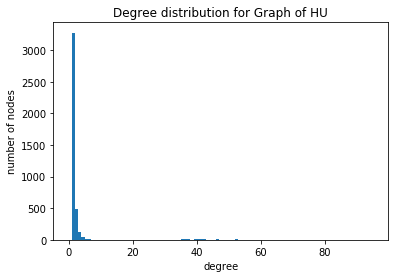

In [311]:
plot_degree_distributions([G])

In [312]:
degree_sequence=sorted(dict(nx.degree(G)).values(),reverse=True)

print(len(list(set(unique_subset_df['node_1']).union(set(unique_subset_df2['node_2'])))), len(unique_subset_df), len(unique_subset_df2))


41773 32498 32800


### Create csv from top 5000

In [313]:
header = ["node_1", "node_2"]
subset_df.to_csv(top_5000_subset_directory + csv_name, columns = header)

### Create genre dict from top 5000

In [314]:
with open(os.path.join(data_directory, genre_json)) as infile:
    genre_dict = json.load(infile)
    
unique_nodes = set(subset_df['node_1'].values.tolist() + subset_df['node_2'].values.tolist())
subset_genre_dict = { str(node): genre_dict[str(node)] for node in unique_nodes }

with open(top_5000_subset_directory + genre_json, 'w') as outfile:
    json.dump(subset_genre_dict, outfile)